# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import sys
#Import Numpy
import numpy as np
#Import Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#Import matplot
import matplotlib
import matplotlib.pyplot as plt
# Set plotting options
%matplotlib inline

import random
import copy
import time
import datetime

from collections import namedtuple, deque

In [2]:
from model import Actor, Critic
from dqn_agent import Agent, OUNoise, ReplayBuffer
from dqn_agent import Agent, LR_ACTOR, LR_CRITIC, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY, SD   

In [3]:
from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [4]:
env = UnityEnvironment(file_name="Reacher.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Agent


In [7]:
#Assigning device variable
agent = Agent()

### Training

The code below is to initialize the DDPG network.

In [8]:
def ddpg(n_episodes=1000, max_t=1000, print_every=50):
    
    #An array declared to store the rewards/scores from each reward
    scores_list = []
    
    #scores_window: Passing criteria requires the average score of last 100 entries should be 30
    #Hence we intialized a variable to last 100 enteries
    scores_window_list = deque(maxlen=100) 
    
    #Initialzing a loop for episodes
    for i_episode in range(1, n_episodes+1):

        #Mentioned in the markdown, while training train_mode should be set to True
        env_info = env.reset(train_mode=True)[brain_name]
        
        #Asking the environment to send the current state 
        states = env_info.vector_observations
        
        # Resetting the agent 
        agent.reset()
        
        # initialize the score (for each agent)
        
        #Since we have 20 agents, we need to set the score of each agent to 0.
        single_scores = np.zeros(num_agents)
        
        #Creating a loop for 1 to 1001 time steps, if time step limit is exceeded; ;
        #it means the agent is stuck, break the loop
        for t in range(max_t):
            
            #Returns actions for a given under a given policy
            actions = agent.act(states, add_noise=True)
            
            # Taking the actions
            env_info = env.step(actions)[brain_name]
            
            #After taking the next action we get -> next state for all 20 agents.
            next_states = env_info.vector_observations
            
            #After taking the next action we get -> reward for all 20 agents
            rewards = env_info.rewards
            
            #After taking the next action we get -> Check whether the episode has ended or not; if ended then True
            dones = env_info.local_done
            
            # Agent storing the states, reward, next_states in the replay_buffer, so that it can reshuffle and learn from it without any bias.
            agent.step(states, actions, rewards, next_states, dones)
            
            #After every 15 time steps, agents accesses replay_buffer and learns from it.
            if t % 15 == 0:
                
                #Learns from samples
                agent.learning_from_samples()
  
            #Assigning the new state as current state; meaning changing the state
            states = next_states

            #Adding the received reward to the score
            single_scores += rewards

            #Check if the episode has ended or not
            #Using np.any: Tells us Test whether any array element along a given axis evaluates to True.
            #Using any since there are 20 agents, so we have to check whether any of them is true
            if np.any(dones):
                
                #If done, then come out of the timestep loop
                break

        # save most recent scores
        scores_list.append(single_scores)
        scores_window_list.append(single_scores)
        
        
        #printing the number to see the progress
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window_list)), end="")
        
        
        #After every 50 episodes, the algorithms prints the episode number and the average score
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window_list)))
            
        #After the average_score reaches 30, break the loop and save the weights    
        if np.mean(scores_window_list)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                  i_episode, np.mean(scores_window_list)))
            
            # Saving the models for actor and critic
            torch.save(agent.actor_local.state_dict(), 'saved_actor_model.pth')
            torch.save(agent.critic_local.state_dict(), 'saved_critic_model.pth')
            
            #Breaking the episodes loop
            break
            
    return scores_list

In [9]:
starting_time = time.time()

#Running the ddqn algorithm and storing it a variable scores
scores = ddpg()

ending_time = time.time()

#Time taken for the algorithm to reach the passing criteria.
time_taken = ending_time - starting_time
print ("Time taken in seconds: {}".format(time_taken))

Episode 50	Average Score: 4.14
Episode 100	Average Score: 7.41
Episode 150	Average Score: 12.66
Episode 200	Average Score: 17.49
Episode 250	Average Score: 22.92
Episode 300	Average Score: 26.83
Episode 350	Average Score: 29.76
Episode 356	Average Score: 30.02
Environment solved in 356 episodes!	Average Score: 30.02
Time taken in seconds: 5295.427741765976


### Plotting

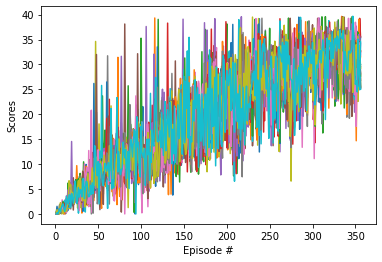

In [10]:
# plot scores vs episodes using matlab
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()

### Loading the Weights

In [7]:
#Initialising the agent.
agent = Agent()

#Loading the saved model 
agent.actor_local.load_state_dict(torch.load('saved_actor_model.pth'))

### Playing the Game Again



In [8]:
#Resetting the environment; setting the training_mode to false
env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    #Instead of selecting random actions like before, now we will use the agent trained using DDPG network. 
    actions = agent.act(states, add_noise=False)       
    
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 28.94549935301766


In [9]:
env.close()